# Exercise 5: Overlap-Save and Partitioned Filtering

### https://en.wikipedia.org/wiki/Overlap%E2%80%93save_method


In this exercise we will regard the convolution of a signal with a given impulse response. The filter
will be applied in the frequency domain using the Overlap-Save method. Additionally, we will pay
special attention to delays caused by long impulse responses. Therefore the impulse response will be
segmented into blocks and the convolution will be processed in a parallel procedure. This partioned
block-wise processing in the frequency domain is called a Partitioned Block Frequency-Domain
Filter (PBFD).

#### Imports and Helper Functions

In [1]:
import numpy as np
import wave
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import Audio, display
from numpy.fft import fft, ifft

In [2]:
def plot_signal(x, sample_rate, *args, **kwargs):
    t = np.r_[:len(x)]*1/sample_rate
    plt.plot(t, x)
    plt.axhline(c='k', alpha=0.75)
    plt.axvline(c='k', alpha=0.75)
    plt.xlabel(kwargs.get('x_label', r'$t / \mathrm{s}$'), fontsize=14)
    plt.ylabel(kwargs.get('y_label', r'$x(t)$'), fontsize=14)
    plt.grid(True)

In [3]:
def show_signal(x, sample_rate, *args, **kwargs):
    display(Audio(x, rate=sample_rate))
    plot_signal(x, sample_rate, *args, **kwargs)

In [4]:
def normalize(x):
    return x / np.abs(x).max()

## Task 5.1 :
How large is the delay of a frequency domain filter approach?

### Solution
The frame-wise processing in the frequency domain results in a processing delay of
$\tau = B/f_\mathrm{S} = M/(2 f_\mathrm{S})$   
with the frame shift $B$,   
the length $M = 2^m$ of the zero-padded impulse response   
and the sampling rate $f_\mathrm{S}$.

Typical values are: $M = 16384,\quad f_\mathrm{S} = 16\,\mathrm{kHz}\quad \Rightarrow \tau = 0.512\,\mathrm{s}$.


## Read in a speech signal and an impulse response

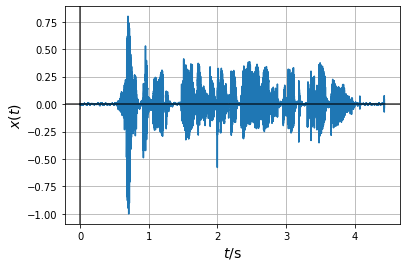

In [21]:
sample_rate, in_signal = read('fg_nt_upb_16k.wav')
in_signal = normalize(in_signal.astype(np.float))
show_signal(in_signal, sample_rate)


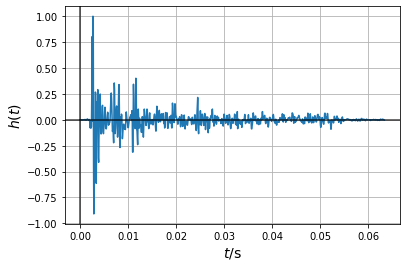

In [6]:
sample_rate_rir, rir = read('raumimpulsantwort.wav')
assert np.isclose(sample_rate_rir, sample_rate), \
    "The sample rates do not match!"
rir = normalize(rir.astype(np.float))
show_signal(rir, sample_rate, y_label=r'$h(t)$')

## Task 5.2

Complete the function `filter_overlap_save`:
1. Perform the convolution in the time domain and measure the processing time.
2. Perform the convolution in the frequency domain using the Overlap-Save method and measure
the processing time.
3. Compare and save both output signals

In [7]:
%timeit normalize(np.convolve(rir, in_signal))

12.4 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


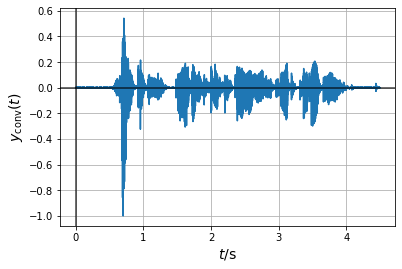

In [8]:
out_conv = normalize(np.convolve(rir, in_signal)) #regular convolution
show_signal(out_conv, sample_rate, y_label=r'$y_\mathrm{conv}(t)$')

In [9]:
def filter_overlap_save(in_signal, impulse_response, fft_length=2048):
    shift = fft_length - len(rir) + 1    # block length B in formulas
    num_blocks = len(in_signal) // shift

    rir_ft = fft(rir, fft_length)
    input_block = np.zeros(fft_length)
    out_signal = np.zeros(num_blocks * shift)

    for m in range(num_blocks):
        input_block[:fft_length-shift] = input_block[shift:]  # 5 REPLACE # TODO
        input_block[fft_length-shift:] = in_signal[m*shift:(m+1)*shift]
        in_ft = fft(input_block, fft_length)
        tmp = ifft(in_ft * rir_ft, fft_length).real
        out_signal[m*shift:(m+1)*shift] = tmp[fft_length-shift:]
    return out_signal

In [10]:
%timeit normalize(filter_overlap_save(in_signal, rir))

5.97 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


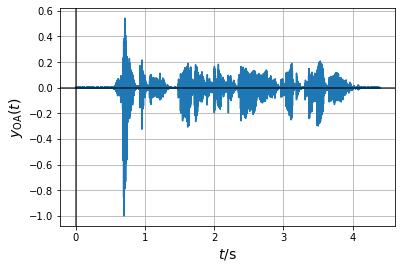

In [11]:
out_overlap_save = normalize(filter_overlap_save(in_signal, rir))
show_signal(out_overlap_save, sample_rate, y_label=r'$y_{\mathrm{OA}}(t)$')

Power of error signal: 2.572e-34


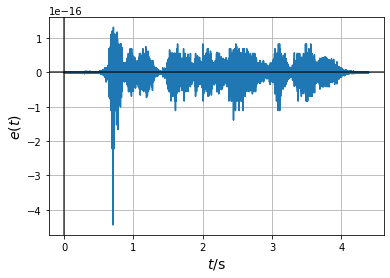

In [12]:
error_signal = out_overlap_save - out_conv[:len(out_overlap_save)]
plot_signal(error_signal, sample_rate, y_label=r'$e(t)$')
print('Power of error signal: {:0.3e}'.format(np.abs(error_signal**2).mean()))

## Task 5.3
Explain the partitioned block frequency-domain filter approach in detail!

### Solution:

The input signal $x(n)$ is convolved with $h(n)$:

\begin{align}
    y(n) = h(n) \ast x(n)
\end{align}

We partition h(n) into $P$ parts of length $N_P$ and execute $P$ filterings in parallel:

\begin{align}
    y(n) = h(n) \ast x(n) &= \left(\sum_{p=0}^{P-1} h_p(n) \right) \ast x(n) \\
    \text{  with   } h_p(n) &= h(n) \cdot r_{N_P}(n - p\cdot N_P)\\
    \text{   and   } r_N(n) &= \begin{cases} 1:& 0 \leq n < N\\
                                            0:& \text{else}
                              \end{cases}
\end{align}

We choose $N_P = B = M/2$, where $M$ is the FFT length and $B$ the block shift. This choice is very relevant in parctice and easier to illustrate.
Before partitioning, the impulse response is padded with zeros to achieve the length $N_h' = P\cdot N_P = P\cdot B$.   

After partitioning, each partition of the impulse response is padded with zeros to the FFT length $M$:

\begin{align}
    w_0(n) &= [ h(0), h(1), \dots, h(B-1), 0, \dots, 0]^\mathrm{T} \\
    w_1(n) &= [ h(B), h(B+1), \dots, h(2 B-1), 0, \dots, 0]^\mathrm{T} \\
    &\ \vdots \\
    w_{P-1}(n) &= [ h((P-1)B), h(P-1)B+1), \dots, h((PB-1), 0, \dots, 0]^\mathrm{T} \\
\end{align}


Due to the linearity of the convolution, we can exchange the order of the summation and convolution:

\begin{align}
    y(n) = \sum_{p=0}^{P-1}\left(h_P(n) \ast x(n) \right) = \sum_{p=0}^{P-1} y_p(n)
\end{align}

Since the $hy_p(n)$ are shifted while the $w_p(n)$ are not, we need to delay $x(n)$ to compensate:

\begin{align}
    y_p(n) = w_p(n) \ast x(n-pB)
\end{align}

Finally, we need to sum the partial results $y_p(n)$:

\begin{align}
    y(n) = \sum_{p=0}^{P-1} y_p(n)
\end{align}

## Task 5.4:
How large is the delay if a PBFD filter is used?

### Solution:
By performing PBFD filtering, a processing delay of $\tau_p = N_P/f_\mathrm{S} = M/(2 f_\mathrm{S}) = \tau/P$ results.

## Task 5.5:
Which disadvantages does the PBFD filter approach show?

### Solution:
- The implementation is a bit more complicated and thus easier to mess up.
- The additional shift and memory load operations add an overhead to the processing time and thus the FFT length might need to be readjusted.
- The memory footprint of the algorithm is enlarged because more buffers are needed


## Load a Long Room Impulse Response

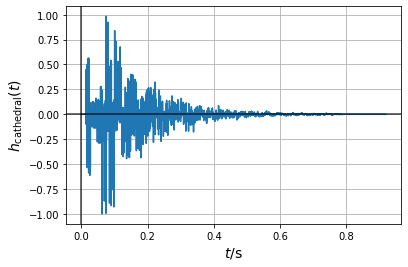

In [13]:
sample_rate_rir_long, rir_long = read('IR_cathedral_16k.wav')
assert np.isclose(sample_rate, sample_rate_rir_long), \
    "The sample rates do not match!"
rir_long = normalize(rir_long.astype(np.float))
show_signal(rir_long, sample_rate, y_label=r'$h_\mathrm{cathedral}(t)$')

## Task 5.6:

Complete the function `partitioned_block_overlap_save`:
1. Extend the previous algorithm to accumulate over all partitions.
2. Perform the convolution also in the time domain to compare the results and processing times.

In [14]:
def partitioned_block_overlap_save(in_signal, impulse_response, fft_length=512):
    
    shift = fft_length // 2
    num_blocks = len(in_signal) // shift
    partitions = len(impulse_response) // shift + 1
    ir_length = partitions * shift
    
    # pad with zeros, thus length is multiple of partitions
    impulse_response = np.r_[
        impulse_response, np.zeros(ir_length - len(impulse_response))]
    # break into partitions and do fft on each
    impulse_response_ft = fft(impulse_response.reshape((partitions, -1)), fft_length)
    
    assert impulse_response_ft.shape == (partitions, fft_length), \
        "Malformed impulse response array after fourier transformation!"

    out_signal = np.zeros(num_blocks*shift)
    input_block = np.zeros(fft_length)
    fft_buffer = np.zeros((partitions, fft_length), dtype=np.complex128)

    for m in range(num_blocks):
        input_block[:-shift] = input_block[shift:]  # 8 REPLACE # TODO
        input_block[fft_length-shift:] = in_signal[m*shift:(m+1)*shift]

        fft_buffer[1:, :] = fft_buffer[:-1, :]
        fft_buffer[0, :] = fft(input_block, fft_length)

        out_buffer = ifft((fft_buffer * impulse_response_ft).sum(axis=0), fft_length).real
        out_signal[m*shift:(m+1)*shift] = out_buffer[-shift:]

    return out_signal

#### Timing of Convolution

In [15]:
%timeit normalize(np.convolve(rir_long, in_signal))

189 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


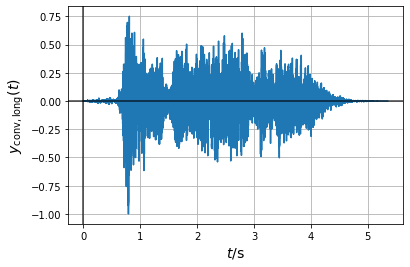

In [16]:
out_conv_long = normalize(np.convolve(rir_long, in_signal))
show_signal(out_conv_long, sample_rate, y_label=r'$y_\mathrm{conv,long}(t)$')

In [17]:
%timeit normalize(partitioned_block_overlap_save(in_signal, rir_long))

45.1 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


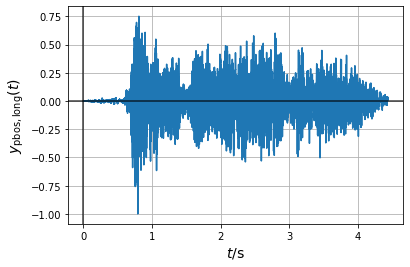

In [18]:
out_pbos = normalize(partitioned_block_overlap_save(in_signal, rir_long))
show_signal(out_pbos, sample_rate, y_label=r'$y_\mathrm{pbos,long}(t)$')

Power of long error signal: 4.072428636033503e-33


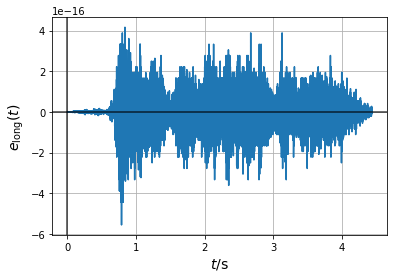

In [19]:
error_long = out_pbos - out_conv_long[:len(out_pbos)]
plot_signal(error_long, sample_rate, y_label=r'$e_\mathrm{long}(t)$')
print("Power of long error signal: {}".format(np.abs(error_long**2).mean()))